In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from scipy.sparse.linalg import eigsh
import bisect
import matplotlib as mpl
import ctypes
import scipy
import matplotlib.pyplot as plt

In [6]:
def cr_spl_predict(x, knots, F):
    """
    pretty much the same as cr_spl, this time evaluating it for already given knots and F
    (could probably just be integrated into cr_spl)
    """

    n = len(x)
    k = len(knots)
    base = np.zeros((n, k))
    for i in range(0, len(x)):
        # in case x[i] is lies outside the range of the knots, extrapolate (see mgcv/src/mgcv.c (crspl) on github)
        if x[i] < min(knots):
            j = 0
            h = knots[1] - knots[0]
            xik = x[i] - knots[0]
            c_jm = -xik * h / 3
            c_jp = -xik * h / 6
            base[i, :] = c_jm * F[0, :] + c_jp * F[1, :]
            base[i, 0] += 1 - xik / h
            base[i, 1] += xik / h
        elif x[i] > max(knots):
            j = len(knots) - 1
            h = knots[j] - knots[j - 1]
            xik = x[i] - knots[j]
            c_jm = xik * h / 6
            c_jp = xik * h / 3
            base[i, :] = c_jm * F[j - 1, :] + c_jp * F[j, 1]
            base[i, j - 1] += -xik / h
            base[i, j] += 1 + xik / h
        # find interval in which x[i] lies and evaluate accordingly just like in cr_spl
        else:
            j = bisect.bisect_left(knots, x[i])
            x_j = knots[j - 1]
            x_j1 = knots[j]
            h = x_j1 - x_j
            a_jm = (x_j1 - x[i]) / h
            a_jp = (x[i] - x_j) / h
            c_jm = ((x_j1 - x[i]) ** 3 / h - h * (x_j1 - x[i])) / 6
            c_jp = ((x[i] - x_j) ** 3 / h - h * (x[i] - x_j)) / 6
            base[i, :] = c_jm * F[j - 1, :] + c_jp * F[j, :]
            base[i, j - 1] += a_jm
            base[i, j] += a_jp
    return base


In [7]:
def get_FS(xk):
    """
    Create matrix F required to build the spline base and the penalizing matrix S,
    based on a set of knots xk (ascending order). Pretty much directly from p.201 in Wood (2017)
    :param xk: knots (for now always np.linspace(x.min(), x.max(), n_knots)
    """
    k = len(xk)
    h = np.diff(xk)
    h_shift_up = h.copy()[1:]


    D = np.zeros((k - 2, k))
    np.fill_diagonal(D, 1 / h[:k - 2])
    np.fill_diagonal(D[:, 1:], (-1 / h[:k - 2] - 1 / h_shift_up))
    np.fill_diagonal(D[:, 2:], 1 / h_shift_up)


    B = np.zeros((k - 2, k - 2))
    np.fill_diagonal(B, (h[:k - 2] + h_shift_up) / 3)
    np.fill_diagonal(B[:, 1:], h_shift_up[k - 3] / 6)
    np.fill_diagonal(B[1:, :], h_shift_up[k - 3] / 6)
    F_minus = np.linalg.inv(B) @ D
    F = np.vstack([np.zeros(k), F_minus, np.zeros(k)])
    S = D.T @ np.linalg.inv(B) @ D
    return F, S


In [13]:
def cr_spl(x, n_knots):
    """

    :param x: x values to be evalutated
    :param n_knots: number of knots
    :return:
    """

    xk = np.linspace(x.min(), x.max(), n_knots)
    n = len(x)
    k = len(xk)
    F, S = get_FS(xk)
    base = np.zeros((n, k))
    for i in range(0, len(x)):
        # find interval in which x[i] lies
        # and evaluate basis function from p.201 in Wood (2017)
        j = bisect.bisect_left(xk, x[i])
        x_j = xk[j - 1]
        x_j1 = xk[j]
        h = x_j1 - x_j
        a_jm = (x_j1 - x[i]) / h
        a_jp = (x[i] - x_j) / h
        c_jm = ((x_j1 - x[i]) ** 3 / h - h * (x_j1 - x[i])) / 6
        c_jp = ((x[i] - x_j) ** 3 / h - h * (x[i] - x_j)) / 6
        base[i, :] = c_jm * F[j - 1, :] + c_jp * F[j, :]
        base[i, j - 1] += a_jm
        base[i, j] += a_jp
    return base, S, xk, F


In [9]:
def scale_penalty(basis, penalty):
    """
    rescale the penalty matrix based on the design matrix of the smoother
    from mgcv to get penalties that react comparably to smoothing parameters
    (works for CubicSplines and MRFSmooth, not for TPSpline since the model
    matrices are completely different)
    """
    X_inf_norm = max(np.sum(abs(basis), axis=1)) ** 2
    S_norm = np.linalg.norm(penalty, ord=1)
    norm = S_norm / X_inf_norm
    penalty = penalty / norm
    return penalty


def identconst(basis, penalty):
    """
    create constraint matrix and absorb identifiability constraint into model matrices:
    returns centered model matrices as well orthogonal factor Z to map centered matrices
    back to unconstrained column space
    """
    constraint_matrix = basis.mean(axis=0).reshape(-1, 1)
    q, r = np.linalg.qr(constraint_matrix, mode="complete")
    penalty = np.double(
        np.linalg.multi_dot([np.transpose(q[:, 1:]), penalty, q[:, 1:]])
    )
    basis = basis @ q[:, 1:]
    return basis, penalty, q[:, 1:]


In [10]:
class CubicSplines:
    def __init__(self, x, k):

        X, S, knots, F = cr_spl(x, n_knots=k)

        # rescale penalty. Contributes to getting pretty much identical penalty matrix as in mgcv
        S = scale_penalty(X, S)
        # center
        X_centered, S_centered, center_mat = identconst(X, S)

        self.basis = X_centered
        self.penalty = S_centered
        self.knots = knots
        self.center_mat = center_mat
        self.gammas = None
        self.deltas = None
        self.x_plot = np.linspace(x.min(), x.max(), 1000).reshape(1000, 1)
        self.dim_basis = X_centered.shape[1]
        self.F = F


    def uncenter(self):
        self.uncentered_gammas = self.center_mat @ self.gammas


    def transform_new(self, x_new):
        # given the knots and F, evaluate new data
        basis = cr_spl_predict(x_new, knots=self.knots, F=self.F)
        return basis


    def plot(self, ax=None, intercept=0, plot_analytical=False, col='b', alpha=1, col_analytical='r'):

        # evaluate x_plot
        basis = cr_spl_predict(self.x_plot, knots=self.knots, F=self.F)
        # create fitted_values
        y_fitted = intercept + basis @ self.uncentered_gammas

        # plot into given subplot or simply new plot
        if ax is None:
            # if least squares solution should be plotted ...
            if plot_analytical:
                y_plot = intercept + basis @ self.center_mat @ self.analytical_gammas
                plt.plot(self.x_plot, y_plot, col_analytical)
            plt.plot(self.x_plot, y_fitted, col=col, alpha=alpha)

        else:
            if plot_analytical:
                y_plot = intercept + basis @ self.center_mat @ self.analytical_gammas
                ax.plot(self.x_plot, y_plot, col_analytical)
            ax.plot(self.x_plot, y_fitted, col, alpha=alpha)


In [11]:
# prompt: simulate some data with two variables and a y target variable which is the sum of the two feature effects

import numpy as np
n = 1000
x1 = np.random.uniform(-1, 1, n)
x2 = np.random.uniform(-5, 5, n)
y = x1**2 + np.sin(x2) + np.random.normal(0, 0.01, n)

x =  np.vstack([x1, x2]).T


In [16]:

splines = [CubicSplines(x[:,i], k=12) for i in range(x.shape[1])]
X = np.hstack([spline.basis for spline in splines])

In [20]:
splines

In [17]:
smoothing_params = [0.0, 0.0]
penalties = [smoothing_params[i] * splines[i].penalty for i in range(x.shape[1])]
S = scipy.linalg.block_diag(*penalties)

In [18]:

analytical_gammas = np.linalg.inv(X.T @ X + S) @X.T @ y
for i in range(len(splines)):
    lower = splines[i].dim_basis * i
    upper = splines[i].dim_basis * (i+1)
    splines[i].analytical_gammas = analytical_gammas[lower: upper]
    splines[i].gammas = analytical_gammas[lower: upper]
    splines[i].uncenter()

C:\Users\schleem\AppData\Local\Temp\ipykernel_8620\2404835405.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base[i, j - 1] += a_jm
C:\Users\schleem\AppData\Local\Temp\ipykernel_8620\2404835405.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base[i, j] += a_jp


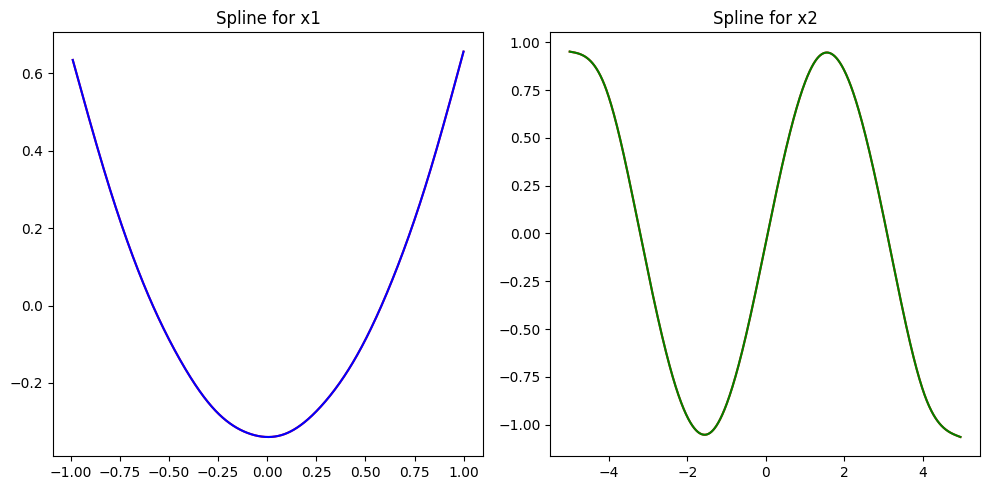

In [19]:
# prompt: do you see the error below? I want to plot both splines...can you help me?

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from scipy.sparse.linalg import eigsh
import bisect
import matplotlib as mpl
import ctypes
import scipy
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first spline
splines[0].plot(ax=axes[0], intercept=0, plot_analytical=True, col='b', alpha=1, col_analytical='r')
axes[0].set_title("Spline for x1")

# Plot the second spline
splines[1].plot(ax=axes[1], intercept=0, plot_analytical=True, col='g', alpha=1, col_analytical='r')
axes[1].set_title("Spline for x2")

# Show the plots
plt.tight_layout()
plt.show()
